In [1]:
%cd ..


/Users/eliaweiss/ai/segmentation/MobileSAM


In [2]:
import numpy as np
from TableDetect import TableDetect
from MobileSamBoxes import MobileSamBoxes
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt
import torch

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

  
def plot_results(model, pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color=c, linewidth=3))
        cl = p.argmax().item()
        score = p[cl]
        text = f'{model.config.id2label[cl]}: {score:0.2f}'
        
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
        
def show_anns(anns):
    if len(anns) == 0:
        return
    ax = plt.gca()
    ax.set_autoscale_on(False)
    img = np.ones((anns.shape[1], anns.shape[2], 4))
    # img[:,:,3] = 0
    for ann in range(anns.shape[0]):
        m = anns[ann].bool()
        m=m.cpu().numpy()
        color_mask = np.concatenate([np.random.random(3), [1]])
        img[m] = color_mask
    ax.imshow(img)


def plot_annotations(anns):
    plt.figure(figsize=(10,10))
    background=np.ones_like(sam.image)*255
    plt.imshow(background)
    show_anns(anns)
    plt.axis('off')
    plt.show() 
    # plt.savefig("{}".format("./out/result.jpg"), bbox_inches='tight', pad_inches = 0.0)         


# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score),
                            'bbox': [float(elem) for elem in bbox]})

    return objects

/Users/eliaweiss/ai/segmentation/MobileSAM/MobileSAMv2/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with tinyvit.tiny_vit.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaweiss/ai/segmentation/MobileSAM/MobileSAMv2/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with tinyvit.tiny_vit.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaweiss/ai/segmentation/MobileSAM/MobileSAMv2/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with tinyvit.tiny_vit.tiny_vit_21m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaweiss/ai/segmentation/

In [3]:
# file_path = "./app/assets/picture1.jpg"
# file_path = "/Users/eliaweiss/Documents/doc2txt/sihach/attachments/img/20231025012642_001.jpg"
file_path = "/Users/eliaweiss/Documents/doc2txt/sihach/need fix/4e7d4235deff4ee2b72d886e12ad0bcf.jpg"

# file_path = "/Users/eliaweiss/Documents/doc2txt/invoices 2/expense (6).jpeg"

img = Image.open(file_path)
tblDec = TableDetect()
probas, boxes = tblDec.detectTables(img)



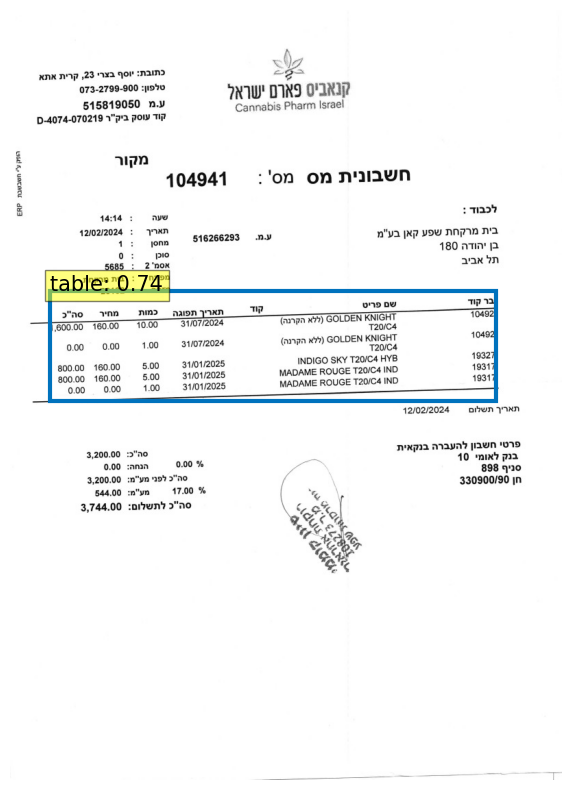

In [4]:
plot_results(tblDec.model, img, probas, boxes)


# Crop table with sam

In [ ]:
sam = MobileSamBoxes(img)
anns = sam.process(boxes)

checkpoint_load_scucess
shape (1201, 1706, 3)
------ total time: (s): 5.72


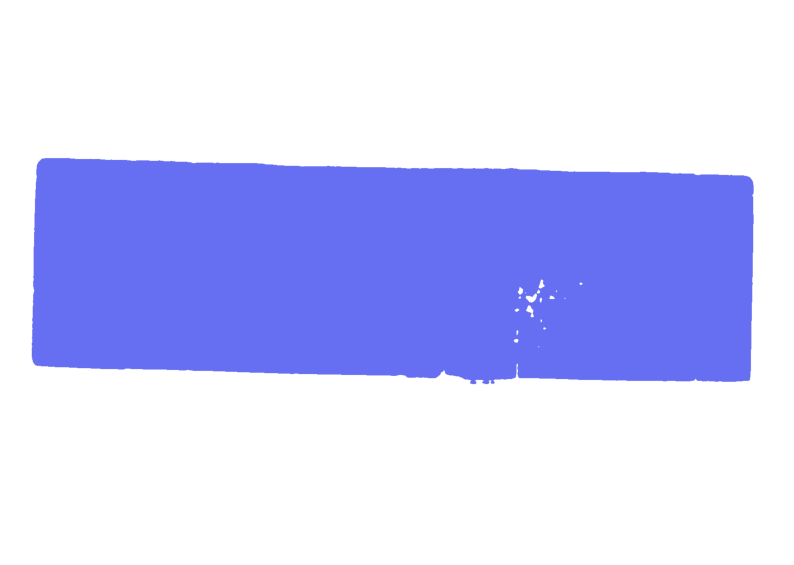

In [ ]:
plot_annotations(anns)



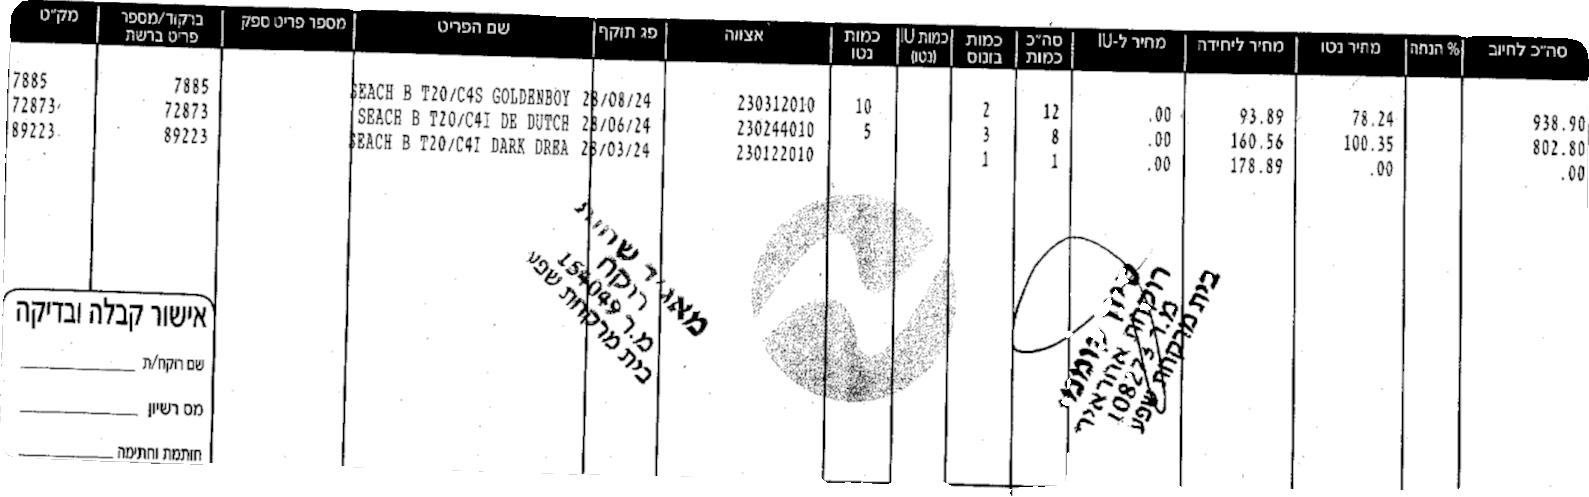

In [ ]:
from PIL import Image
import cv2

def create_mask_patch(image, mask):
  """
  Creates a patch from the image containing only the mask region.

  Args:
      image: A PIL image object.
      mask: A NumPy array representing the mask (1 for mask pixels).

  Returns:
      A PIL image object containing the patch from the original image 
      with only the mask region and white background for non-mask pixels.
  """
  mask=mask.cpu().numpy()
  # mask = cv2.dilate(mask, np.ones((13, 13), np.uint8), iterations=1)  
  # Find non-zero elements (mask pixels) in the mask
  mask_coords = np.where(mask != 0)

  # Get minimum and maximum coordinates from the mask pixels
  min_y, min_x = mask_coords[0].min(), mask_coords[1].min()
  max_y, max_x = mask_coords[0].max() + 1, mask_coords[1].max() + 1  # Add 1 for inclusive range

  # Create the bounding box rectangle
  bounding_box = (min_x, min_y, max_x, max_y)


  mask = mask==1
  imgArr = np.array(image)
  imgArr[~mask] = (255,255,255)
  image = Image.fromarray(imgArr)
  # color_mask = np.concatenate([np.random.random(3), [1]])
  # img[m] = color_mask
  # Crop the image using the bounding box
  patch_image = image.crop(bounding_box)
  return patch_image

# Example usage
mask = anns[0]

tbl_patch = create_mask_patch(img, mask)
# patch.show()  # Display the created patch
tbl_patch


# Table structure recognition

In [ ]:
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor()
encoding = feature_extractor(tbl_patch, return_tensors="pt")
encoding.keys()

/Users/eliaweiss/opt/anaconda3/envs/mobileSam/lib/python3.10/site-packages/transformers/models/detr/feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


dict_keys(['pixel_values', 'pixel_mask'])

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from transformers import TableTransformerForObjectDetection

# new v1.1 checkpoints require no timm anymore
structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")
structure_model.to(device)
""

''

In [ ]:
from torchvision import transforms

class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize((int(round(scale*width)), int(round(scale*height))))

        return resized_image
structure_transform = transforms.Compose([
    MaxResize(1000),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
pixel_values = structure_transform(tbl_patch).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 313, 1000])


In [ ]:
# forward pass
with torch.no_grad():
  outputs = structure_model(pixel_values)

In [ ]:
# update id2label to include "no object"
structure_id2label = structure_model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"

cells = outputs_to_objects(outputs, tbl_patch.size, structure_id2label)
print(cells)

[{'label': 'table column', 'score': 0.9990293979644775, 'bbox': [95.71085357666016, 5.0854082107543945, 223.45716857910156, 461.23162841796875]}, {'label': 'table column', 'score': 0.9123596549034119, 'bbox': [1308.3695068359375, 4.9343581199646, 1416.447509765625, 461.0538024902344]}, {'label': 'table column', 'score': 0.9978212118148804, 'bbox': [689.7669677734375, 5.329298973083496, 827.2062377929688, 459.9444274902344]}, {'label': 'table column', 'score': 0.9586437344551086, 'bbox': [1035.8660888671875, 5.148728847503662, 1101.5181884765625, 461.0990295410156]}, {'label': 'table projected row header', 'score': 0.6559820771217346, 'bbox': [4.954278469085693, 251.79812622070312, 1588.1268310546875, 325.50201416015625]}, {'label': 'table column', 'score': 0.7274317741394043, 'bbox': [953.0676879882812, 5.2111897468566895, 1010.595458984375, 463.3824157714844]}, {'label': 'table projected row header', 'score': 0.9226821064949036, 'bbox': [5.099945068359375, 324.35003662109375, 1588.074

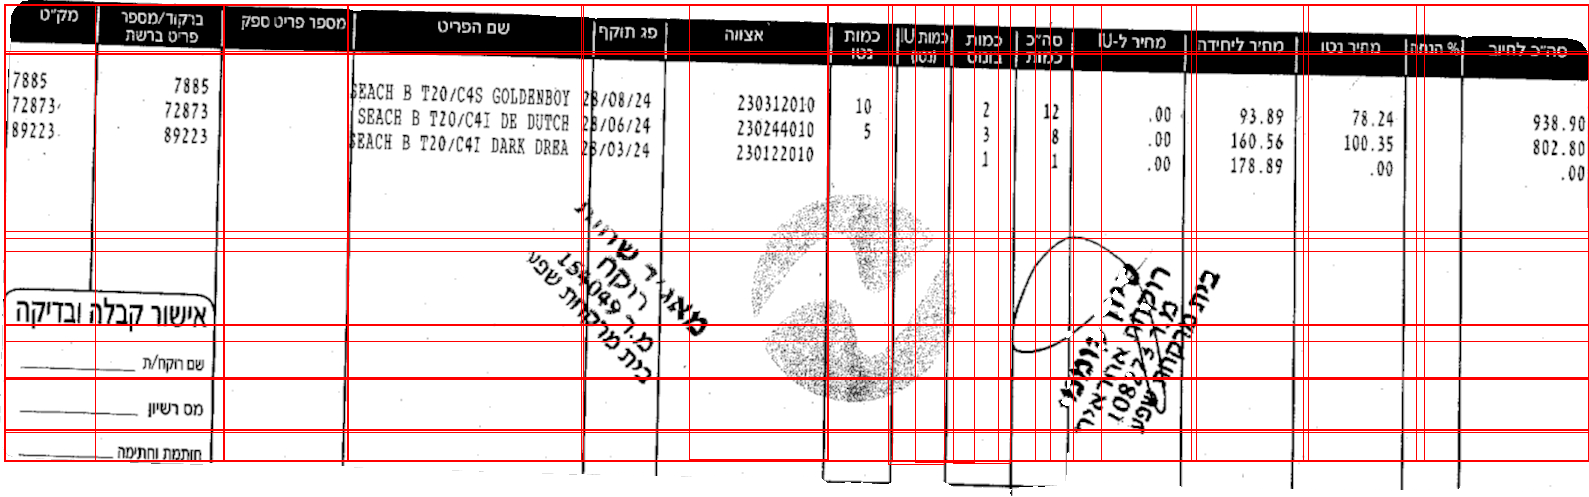

In [ ]:
from PIL import ImageDraw

cropped_table_visualized = tbl_patch.copy()
draw = ImageDraw.Draw(cropped_table_visualized)

for cell in cells:
    draw.rectangle(cell["bbox"], outline="red")

cropped_table_visualized

In [ ]:
def plot_results(tbl_patch, cells, class_to_visualize):
    if class_to_visualize not in structure_model.config.id2label.values():
      raise ValueError(f"Class should be one of the available classes {structure_model.config.id2label}")

    plt.figure(figsize=(16,10))
    plt.imshow(tbl_patch)
    ax = plt.gca()

    for cell in cells:
        bbox = cell["bbox"]
        label = cell["label"]

        if label == class_to_visualize:
          xmin, ymin, xmax, ymax = tuple(bbox)

          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=3))
          plt.axis('off')

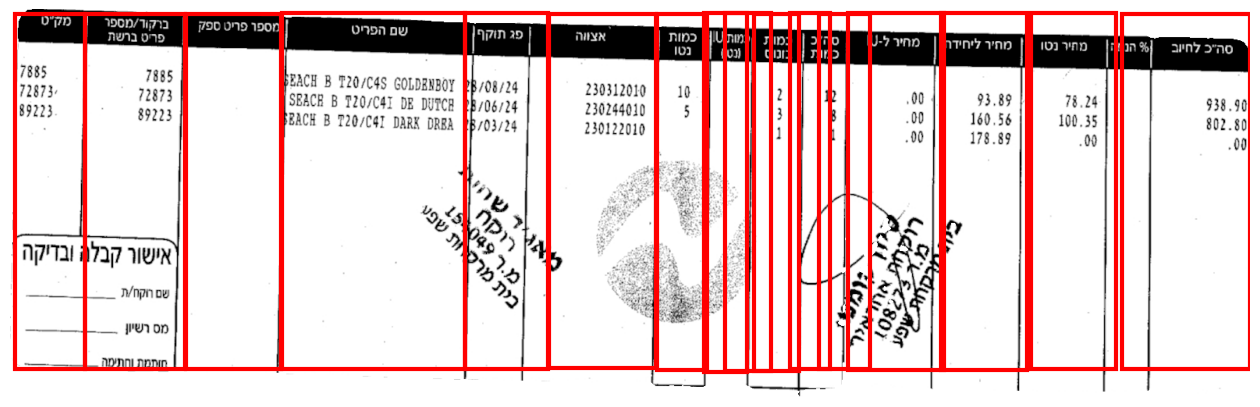

In [ ]:
# plot_results(cells, class_to_visualize="table row")
plot_results(tbl_patch, cells, class_to_visualize="table column")
# plot_results(cells, class_to_visualize="table column header")
# plot_results(cells, class_to_visualize="table projected row header")
# plot_results(cells, class_to_visualize="table spanning cell")

# align table

In [ ]:
m = anns[0].bool()
m=m.cpu().numpy()
mask = np.zeros((anns.shape[1], anns.shape[2], 1), np.uint8)
mask[m] = 255
# mask = ~mask
print(mask.shape)
print(mask.dtype)

(1201, 1706, 1)
uint8


In [ ]:
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour = contours[0]

In [ ]:
image = np.array(img)

In [ ]:
def calcBB():
    mask_coords = np.where(mask != 0)

# Get minimum and maximum coordinates from the mask pixels
    min_y, min_x = mask_coords[0].min(), mask_coords[1].min()
    max_y, max_x = mask_coords[0].max() + 1, mask_coords[1].max() + 1  # Add 1 for inclusive range

# Define the dimensions of the output rectangle
    width = max_x-min_x  # Define your desired width here
    height = max_y-min_y  # Define your desired height here
    return (min_x, max_x), (min_y, max_y), (width,height)



In [ ]:


import cv2
import numpy as np

def find_closest_point_in_contour(contour, point_xy):
   """
   Finds the closest point within a contour to a given point.

   Args:
       contour: A NumPy array representing the contour, where each row is a (x, y) point.
       point_xy: A tuple of (x, y) coordinates for the reference point.

   Returns:
       A tuple representing the (x, y) coordinates of the closest point in the contour.
   """

   min_dist = np.inf
   closest_point = None

   for contour_point in contour:
       x, y = contour_point[0]
       dist = np.sqrt((x - point_xy[0])**2 + (y - point_xy[1])**2)
       if dist < min_dist:
           min_dist = dist
           closest_point = x, y

   return closest_point

def approxBoundingQuadrilateral(find_closest_point_in_contour):
    (min_x, max_x), (min_y, max_y), (width,height) = calcBB()
    lb = find_closest_point_in_contour(contour, (min_x,min_y))
    lt = find_closest_point_in_contour(contour, (min_x,max_y))
    rt = find_closest_point_in_contour(contour, (max_x,max_y))
    rb = find_closest_point_in_contour(contour, (max_x,min_y))
    # return clock wise
    return (lb,rb, rt, lt), (width,height)

boundingQuadrilateral, (width,height) = approxBoundingQuadrilateral(find_closest_point_in_contour)
boundingQuadrilateral

((62, 337), (1624, 368), (1627, 816), (59, 784))

In [ ]:

# Convert the vertices of the quadrilateral to a numpy array
# pts1 = np.float32(approx)
pts1 = np.float32(boundingQuadrilateral)

# Define the corners of the rectangle
# pts2 = np.float32([[0, 0], [0, height], [width, height] , [width, 0]])
pts2 = np.float32([[0, 0], [width, 0], [width, height], [0, height]]) 


# Compute the perspective transformation matrix
matrix = cv2.getPerspectiveTransform(pts1, pts2)
 
# Apply the perspective transformation to the original image
result = cv2.warpPerspective(image, matrix, (width, height))

# Display the result
# cv2.imshow('Aligned Image', result)
# cv2.waitKey(0)
alignTable = Image.fromarray(result)
alignTable

# Find cell from align tbl

In [ ]:
pixel_values = structure_transform(alignTable).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 313, 1000])


In [ ]:
# forward pass
with torch.no_grad():
  outputs = structure_model(pixel_values)

In [ ]:
# update id2label to include "no object"
structure_id2label = structure_model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"

cells = outputs_to_objects(outputs, alignTable.size, structure_id2label)
print(cells)

[{'label': 'table column', 'score': 0.9960899353027344, 'bbox': [83.87068176269531, -0.34785404801368713, 211.11720275878906, 496.5259704589844]}, {'label': 'table column', 'score': 0.9963894486427307, 'bbox': [1413.52587890625, -0.1785408854484558, 1480.953125, 496.7037048339844]}, {'label': 'table column', 'score': 0.9986182451248169, 'bbox': [687.938232421875, 0.10864421725273132, 830.7821655273438, 496.98333740234375]}, {'label': 'table column', 'score': 0.9988407492637634, 'bbox': [1086.416748046875, 0.16633599996566772, 1191.4295654296875, 497.08343505859375]}, {'label': 'table column', 'score': 0.5345418453216553, 'bbox': [872.9349975585938, -0.427733838558197, 934.80224609375, 496.4647521972656]}, {'label': 'table column', 'score': 0.5808061957359314, 'bbox': [972.5743408203125, 0.2344256341457367, 1031.189208984375, 497.1056823730469]}, {'label': 'table column', 'score': 0.9993021488189697, 'bbox': [1190.3070068359375, 0.1776966154575348, 1310.531982421875, 497.0533142089844]}

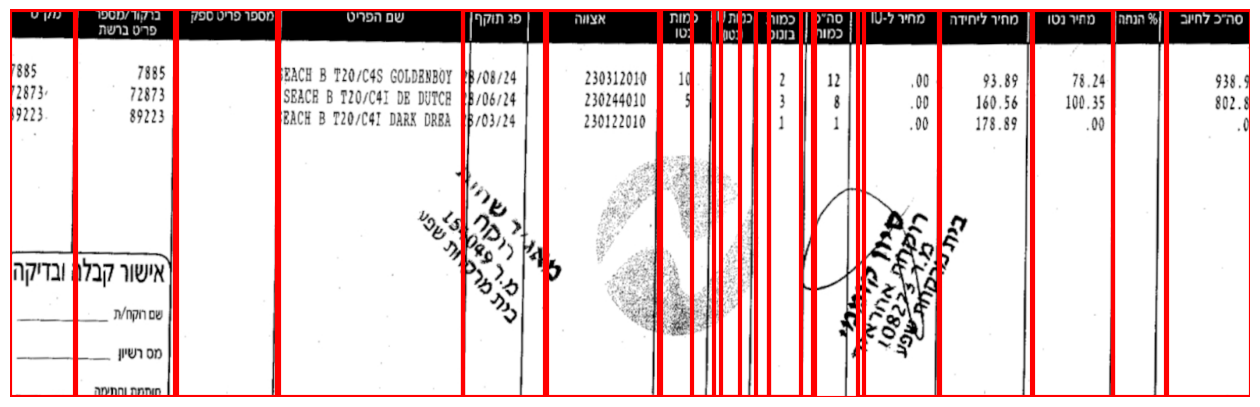

In [ ]:
plot_results(alignTable, cells, class_to_visualize="table column")

# Find the inverse homography matrix

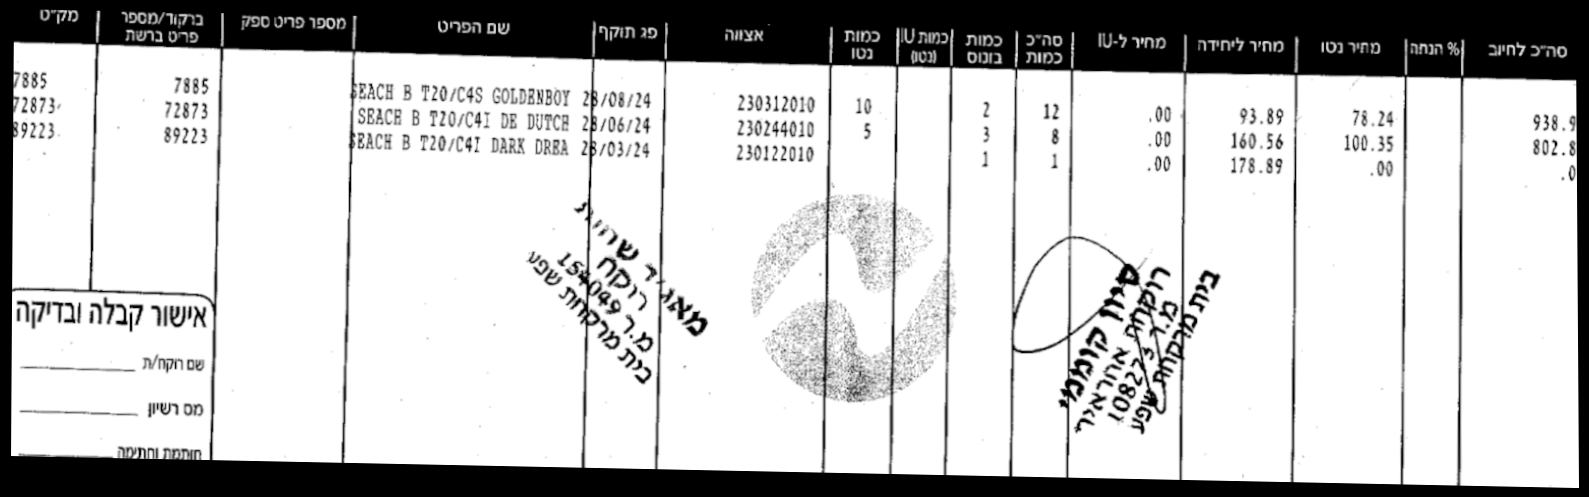

In [ ]:
# Find the inverse homography matrix

pts3 = pts1.copy()
(min_x, max_x), (min_y, max_y), (width,height) = calcBB()
pts3[:,0] -= min_x
pts3[:,1] -= min_y
inv_matrix = cv2.findHomography(pts2, pts3)[0]

# Reverse warp the image
reversed_result = cv2.warpPerspective(result, inv_matrix, (width, height))
reversedTbl = Image.fromarray(reversed_result)
reversedTbl
